In [35]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor



# import os, sys; sys.path.append(os.path.dirname(os.path.realpath("LEN_Test/pytorch_explain/experiments/elens/")))
# from load_datasets import load_mimic


In [36]:
mimicDF = pd.read_csv("../LEN_Test/data/TimeSeries.csv")
# targetDF = mimicDF['Mortality14Days']
# mimicDF = mimicDF.drop(['Mortality14Days'], axis=1)
mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [38]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [39]:
# class Reading:

#     def __init__(self, time, readingData):
#         self.time = time
#         self.readingData = readingData

#     def __repr__(self):
#         return f"Time_index: {self.time}\n Data: {self.readingData}"

In [40]:
class Patient:

    def __init__(self, patientID, data):
        self.patientID = patientID
        self.data = data
        self.interpolatedData = pd.DataFrame()


    def __repr__(self):
        return f"PatientID: {self.patientID}\n Readings: {self.data}"
    

In [41]:
for id in mimicDF['PatientID'].unique()[:1]:
    patientDF = mimicDF[mimicDF['PatientID'] == id]
    display(patientDF)

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
patients = []

for id in mimicDF['PatientID'].unique():
    patientDF = mimicDF[mimicDF['PatientID'] == id].reset_index().drop(columns=['PatientID', 'index'])
    patient = Patient(id, patientDF)
    patients.append(patient)

print(len(patients))

1126


In [43]:
print(patients[1].data)

    Mortality14Days  ALT  AST  Admit Ht  Albumin  Arterial BP Mean  \
0                 0  NaN  NaN       NaN      NaN              84.0   
1                 0  NaN  NaN       NaN      NaN              85.0   
2                 0  NaN  NaN       NaN      NaN              84.0   
3                 0  NaN  NaN       NaN      NaN              91.0   
4                 0  NaN  NaN       NaN      NaN              68.0   
5                 0  NaN  NaN       NaN      NaN              82.0   
6                 0  NaN  NaN      68.0      NaN               NaN   
7                 0  NaN  NaN       NaN      NaN              72.0   
8                 0  NaN  NaN       NaN      NaN              68.0   
9                 0  NaN  NaN       NaN      NaN              71.0   
10                0  NaN  NaN       NaN      NaN              70.0   
11                0  NaN  NaN       NaN      NaN              84.0   
12                0  NaN  NaN       NaN      NaN              85.0   
13                0 

In [44]:
cleaningDF = patients[1].data
cleaningDF.head()

,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,0,NaN,NaN,NaN,NaN,84.0,46.0,116.0,NaN,NaN,...,21.844700,1094.020020,2255.510010,NaN,NaN,97.0,NaN,37.200001,NaN,NaN
1,0,NaN,NaN,NaN,NaN,85.0,60.0,129.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.200001,NaN,NaN
2,0,NaN,NaN,NaN,NaN,84.0,54.0,117.0,42.0,90.0,...,NaN,NaN,NaN,NaN,NaN,99.0,NaN,37.099998,NaN,NaN
3,0,NaN,NaN,NaN,NaN,91.0,55.0,125.0,NaN,NaN,...,25.242701,1146.900024,2364.959961,NaN,NaN,93.0,NaN,37.000000,NaN,NaN
4,0,NaN,NaN,NaN,NaN,68.0,43.0,96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,93.0,NaN,36.799999,NaN,NaN


In [45]:
columnsToInterpolate = ['Glucose']

noInterpolation = 0

for patient in patients:
    try:
        patient.interpolatedData[columnsToInterpolate] = patient.data[columnsToInterpolate].apply(lambda x: x.interpolate(method='polynomial', order=2))
    except ValueError:
        patient.interpolatedData[columnsToInterpolate] = patient.data[columnsToInterpolate]
        noInterpolation += 1
        continue

print(f"{noInterpolation}/{len(patients)} patients have no missing values")

65/1126 patients have no missing values


In [46]:

# for patient in patients:
#     plt.scatter(patient.interpolatedData.index, patient.interpolatedData['Glucose'])
#     plt.scatter(patient.data.index, patient.data['Glucose'],c='black')


# plt.show()

# [plt.scatter(patient.data.index, patient.data['Glucose']) for patient in interpolatedPatients[:5]]

In [47]:
dataDF = pd.DataFrame([patient.interpolatedData['Glucose'].values for patient in patients]).fillna(patient.interpolatedData["Glucose"].mean())

data = dataDF.to_numpy()

dataFormatted = to_time_series_dataset([*data])

# dataFormatted = TimeSeriesScalerMeanVariance().fit_transform(data)

print(data.shape)
print(dataFormatted.shape)


(1126, 48)
(1126, 48, 1)


In [48]:

# clusters = 10

# model = TimeSeriesKMeans(n_clusters=clusters, metric="dtw", max_iter=200, random_state=0)
# y_pred = model.fit_predict(dataFormatted)

# print(silhouette_score(data, y_pred))


# clusterModels = []

# for i in range(2, 5):

#     model = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=200, random_state=0)
#     y_pred = model.fit_predict(dataFormatted)

#     score = silhouette_score(data, y_pred)

#     clusterModels.append([y_pred, score])

#     print(f"{i} clusters sil score: {score}")

# plt.plot([x[1] for x in clusterModels])
# plt.show()

# # print(y_pred)

In [49]:
colours = {0:'r', 1:'g', 2:'b', 3:'c', 4:'m', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'purple', 10:'pink'}


# fig = plt.figure(figsize=(2,15))

# for i in range(clusters):
#     plt.subplot(clusters, 1, i+1)
#     for sample in dataFormatted[y_pred == i][:10]:
#         plt.plot(sample, c=colours[i], alpha=0.2)
#     plt.title(f"Cluster {i+1}")

# plt.tight_layout()

# print(silhouette_score(data, y_pred))

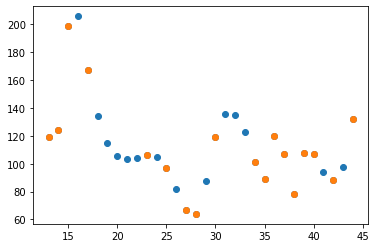

In [50]:

glucoseSeries = patients[3].data[columnsToInterpolate]['Glucose']

generated = glucoseSeries.interpolate(method='polynomial', order=3)

plt.scatter(generated.index, generated)

plt.scatter(glucoseSeries.index, glucoseSeries)

plt.show()

In [51]:
pd.set_option('display.max_rows', 1000)

### Aggregating the dataset using expert values

In [52]:
# Aggregating the dataset

staticPatients = []

target = []

for patient in patients:

    curr = {}

    df = patient.data

    # curr['PatientID'] = patient.patientID
    target.append(df['Mortality14Days'].max())
    curr['ALT'] = df['ALT'].max()
    curr['AST'] = df['AST'].max()
    curr['Admit_Ht'] = df['Admit Ht'].max()
    curr['Albumin'] = df['Albumin'].min()
    curr['Arterial_BP_Mean'] = df['Arterial BP Mean'].min()
    curr['Arterial_BP_Diastolic'] = df['Arterial BP [Diastolic]'].min()
    curr['Arterial_BP_Systolic'] = df['Arterial BP [Systolic]'].min()
    curr['Arterial_PaCO2'] = df['Arterial PaCO2'].min()
    curr['Arterial_PaO2'] = df['Arterial PaO2'].min()
    curr['Arterial_pH_Max'] = df['Arterial pH'].max()
    curr['Arterial_pH_Min'] = df['Arterial pH'].min()
    curr['Urea'] = df['BUN'].min() * 0.357
    curr['CVP_Min'] = df['CVP'].min()
    curr['CVP_Max'] = df['CVP'].max()
    curr['CaO2'] = df['CaO2'].min()
    curr['Chloride'] = df['Chloride'].min()
    curr['Creatinine'] = df['Creatinine'].min()
    curr['Daily_Weight'] = df['Daily Weight'].loc[df['Daily Weight'].first_valid_index()] / 2.205 if df['Daily Weight'].first_valid_index() is not None else None
    curr['Fibrinogen'] = df['Fibrinogen'].max()
    curr['Glucose_Max'] = df['Glucose'].max()
    curr['Glucose_Min'] = df['Glucose'].min()
    curr['Heart_Rate_Min'] = df['Heart Rate'].min()
    curr['Heart_Rate_Max'] = df['Heart Rate'].max()
    curr['Hamoglobin'] = df['Hemoglobin'].min()
    curr['INR'] = df['INR'].max()
    curr['Ionized_Calcium'] = df['Ionized Calcium'].min()
    curr['LDH'] = df['LDH'].max()
    curr['Magnesium'] = df['Magnesium'].min()
    curr['NBP_Mean'] = df['NBP Mean'].min()
    curr['NBP_Diastolic'] = df['NBP [Diastolic]'].min()
    curr['NBP_Systolic'] = df['NBP [Systolic]'].min()
    curr['PTT'] = df['PTT'].max()
    curr['Platelets'] = df['Platelets'].min()
    curr['Potassium_Max'] = df['Potassium'].max()
    curr['Potassium_Min'] = df['Potassium'].min()
    curr['Resp_Rate_(Spont)_Min'] = df['Resp Rate (Spont)'].min()
    curr['Resp_Rate_(Spont)_Max'] = df['Resp Rate (Spont)'].max()
    curr['SVI'] = df['SVI'].min()
    curr['SVRI_Max'] = df['SVRI'].max()
    curr['SVRI_Min'] = df['SVRI'].min()
    curr['SaO2'] = df['SaO2'].min()
    curr['Sodium_Max'] = df['Sodium'].max()
    curr['Sodium_Min'] = df['Sodium'].min()
    curr['SpO2'] = df['SpO2'].min()
    curr['SvO2_Max'] = df['SvO2'].max()
    curr['SvO2_Min'] = df['SvO2'].min()
    curr['Temperature_C_Max'] = df['Temperature C'].max()
    curr['Temperature_C_Min'] = df['Temperature C'].min()
    curr['Bilirubin'] = df['Total Bili'].max()
    curr['White_Blood_Cells_Max'] = df['WBC'].max()
    curr['White_Blood_Cells_Min'] = df['WBC'].min()

    staticPatients.append(curr)


staticPatientsDF = pd.DataFrame([x.values() for x in staticPatients], columns=curr.keys())

targetSeries = pd.Series(data=target)

display(targetSeries)

display(staticPatientsDF)

0       0
1       0
2       0
3       0
4       0
       ..
1121    0
1122    0
1123    0
1124    0
1125    0
Length: 1126, dtype: int64

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
0,NaN,NaN,65.0,NaN,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,NaN,NaN,38.799999,35.700001,NaN,12.1,8.2
1,NaN,NaN,68.0,NaN,68.0,42.0,96.0,42.0,83.0,7.48,...,NaN,NaN,92.0,NaN,NaN,38.200001,36.799999,NaN,NaN,NaN
2,NaN,NaN,64.0,NaN,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,NaN,NaN,37.700001,36.500000,NaN,13.3,11.3
3,NaN,NaN,70.0,NaN,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,NaN,NaN,38.299999,36.000000,NaN,12.6,12.6
4,NaN,NaN,NaN,NaN,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,NaN,NaN,38.099998,37.200001,NaN,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,NaN,NaN,NaN,NaN,54.0,36.0,88.0,37.0,82.0,7.41,...,NaN,NaN,93.0,NaN,NaN,38.500000,37.099998,NaN,NaN,NaN
1122,NaN,NaN,62.0,NaN,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,NaN,NaN,37.200001,36.099998,NaN,21.3,17.6
1123,NaN,NaN,62.0,NaN,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,NaN,NaN,39.700001,36.500000,NaN,13.7,11.1
1124,11.0,48.0,NaN,NaN,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,NaN,NaN,38.099998,37.599998,4.1,9.9,9.9


In [53]:
staticPatientsDF.describe()

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
count,253.000000,250.000000,663.000000,143.000000,1096.000000,1097.000000,1097.000000,1075.000000,1075.000000,1083.000000,...,742.000000,742.000000,1126.00000,49.000000,49.000000,1126.000000,1126.000000,171.000000,731.000000,731.000000
mean,388.296443,652.108000,67.376471,2.613287,60.073905,43.779398,87.995442,34.494884,90.542763,7.607101,...,139.758760,136.113221,91.58659,68.367347,66.040816,37.029165,35.332380,2.094737,14.690014,11.269494
std,1014.823729,2053.610608,5.529188,0.584451,9.878763,11.453517,21.175211,5.266344,34.024617,5.456490,...,3.570727,7.843155,8.97472,11.305776,11.193300,5.621109,5.680826,2.696976,6.032519,4.910463
min,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,7.470000,7.230000,...,127.000000,1.210000,0.00000,45.000000,43.000000,0.000000,0.000000,0.100000,2.400000,1.900000
25%,19.000000,40.000000,64.000000,2.200000,55.000000,40.000000,82.000000,31.000000,70.000000,7.410000,...,138.000000,134.000000,91.00000,60.000000,57.000000,37.500000,35.700001,0.600000,10.600000,7.800000
50%,40.000000,79.500000,68.000000,2.600000,60.000000,45.000000,90.000000,35.000000,82.000000,7.440000,...,140.000000,136.000000,93.00000,69.000000,67.000000,37.900002,36.299999,1.000000,13.600000,10.600000
75%,220.000000,359.000000,70.000000,3.000000,65.000000,50.000000,98.000000,38.000000,102.500000,7.470000,...,142.000000,139.000000,95.00000,74.000000,74.000000,38.299999,36.900002,2.400000,17.550000,13.850000
max,8100.000000,23060.000000,160.000000,4.400000,106.000000,77.000000,170.000000,66.000000,389.000000,187.000000,...,164.000000,152.000000,100.00000,100.000000,98.000000,46.500000,38.900002,16.400000,48.300000,48.300000


In [54]:
## Columns containing NaN values

colsWithNa = staticPatientsDF.isnull().any()

colsWithNa.where(colsWithNa == True).dropna()

ALT                      True
AST                      True
Admit_Ht                 True
Albumin                  True
Arterial_BP_Mean         True
Arterial_BP_Diastolic    True
Arterial_BP_Systolic     True
Arterial_PaCO2           True
Arterial_PaO2            True
Arterial_pH_Max          True
Arterial_pH_Min          True
Urea                     True
CVP_Min                  True
CVP_Max                  True
CaO2                     True
Chloride                 True
Creatinine               True
Daily_Weight             True
Fibrinogen               True
Glucose_Max              True
Glucose_Min              True
Hamoglobin               True
INR                      True
Ionized_Calcium          True
LDH                      True
Magnesium                True
NBP_Mean                 True
NBP_Diastolic            True
NBP_Systolic             True
PTT                      True
Platelets                True
Potassium_Max            True
Potassium_Min            True
Resp_Rate_

In [55]:
staticPatientsDF.isna().sum()

ALT                       873
AST                       876
Admit_Ht                  463
Albumin                   983
Arterial_BP_Mean           30
Arterial_BP_Diastolic      29
Arterial_BP_Systolic       29
Arterial_PaCO2             51
Arterial_PaO2              51
Arterial_pH_Max            43
Arterial_pH_Min            43
Urea                      388
CVP_Min                    36
CVP_Max                    36
CaO2                      313
Chloride                  389
Creatinine                388
Daily_Weight              408
Fibrinogen                795
Glucose_Max               382
Glucose_Min               382
Heart_Rate_Min              0
Heart_Rate_Max              0
Hamoglobin                 45
INR                       442
Ionized_Calcium            73
LDH                       991
Magnesium                 445
NBP_Mean                  519
NBP_Diastolic             516
NBP_Systolic              501
PTT                       444
Platelets                  25
Potassium_

In [56]:
# Doing Arterial BP Mean

# Create Pytorch model

# X_train = staticPatientsDF[~staticPatientsDF['Arterial_BP_Mean'].isnull()]

# X_train


In [57]:
fillNaModeDF = staticPatientsDF.copy()

for col in fillNaModeDF:
    # print(staticPatientsDF[col].value_counts())
    fillNaModeDF[col] = fillNaModeDF[col].fillna(fillNaModeDF[col].mode()[0])

display(fillNaModeDF)

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
0,11.0,29.0,65.0,2.6,64.0,48.0,99.0,39.0,80.0,7.50,...,138.0,133.0,90.0,71.0,53.0,38.799999,35.700001,0.4,12.1,8.2
1,11.0,29.0,68.0,2.6,68.0,42.0,96.0,42.0,83.0,7.48,...,141.0,137.0,92.0,71.0,53.0,38.200001,36.799999,0.4,13.3,8.0
2,11.0,29.0,64.0,2.6,63.0,46.0,86.0,37.0,84.0,7.40,...,136.0,134.0,93.0,71.0,53.0,37.700001,36.500000,0.4,13.3,11.3
3,11.0,29.0,70.0,2.6,57.0,46.0,77.0,31.0,65.0,7.46,...,137.0,131.0,93.0,71.0,53.0,38.299999,36.000000,0.4,12.6,12.6
4,11.0,29.0,70.0,2.6,60.0,43.0,95.0,45.0,93.0,7.35,...,142.0,141.0,82.0,71.0,53.0,38.099998,37.200001,0.4,17.4,13.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,11.0,29.0,70.0,2.6,54.0,36.0,88.0,37.0,82.0,7.41,...,141.0,137.0,93.0,71.0,53.0,38.500000,37.099998,0.4,13.3,8.0
1122,11.0,29.0,62.0,2.6,48.0,40.0,78.0,30.0,105.0,7.39,...,137.0,133.0,68.0,71.0,53.0,37.200001,36.099998,0.4,21.3,17.6
1123,11.0,29.0,62.0,2.6,64.0,50.0,77.0,32.0,56.0,7.40,...,145.0,142.0,91.0,71.0,53.0,39.700001,36.500000,0.4,13.7,11.1
1124,11.0,48.0,70.0,2.6,55.0,42.0,80.0,35.0,61.0,7.50,...,140.0,140.0,93.0,71.0,53.0,38.099998,37.599998,4.1,9.9,9.9


In [58]:
cat = Categorizer(fillNaModeDF)

# cat.kBins(bins = 5)
cat.agglomerative(n_clusters = 5)
# cat.kMeans(n_clusters = 5)

# cat.display(num=3)

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
0,0,0,1,1,2,2,3,3,1,3,...,1,2,3,2,0,3,3,0,1,0
1,0,0,2,1,3,1,2,3,1,3,...,2,3,3,2,0,3,4,0,1,0
2,0,0,0,1,2,2,2,2,1,1,...,1,2,3,2,0,2,4,0,1,1
3,0,0,2,1,1,2,1,1,0,2,...,1,1,3,2,0,3,3,0,1,2
4,0,0,2,1,2,1,2,4,1,0,...,2,4,2,2,0,2,4,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,2,1,1,1,2,2,1,1,...,2,3,3,2,0,3,4,0,1,0
1122,0,0,0,1,1,1,1,1,2,1,...,1,2,1,2,0,1,3,0,2,3
1123,0,0,0,1,2,2,1,1,0,1,...,3,4,3,2,0,3,4,0,1,1
1124,0,0,2,1,1,1,1,2,0,3,...,2,3,3,2,0,2,4,2,0,1


In [59]:
cat.categorizationTypes['agglomerative']

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
0,0,0,1,1,2,2,3,3,1,3,...,1,2,3,2,0,3,3,0,1,0
1,0,0,2,1,3,1,2,3,1,3,...,2,3,3,2,0,3,4,0,1,0
2,0,0,0,1,2,2,2,2,1,1,...,1,2,3,2,0,2,4,0,1,1
3,0,0,2,1,1,2,1,1,0,2,...,1,1,3,2,0,3,3,0,1,2
4,0,0,2,1,2,1,2,4,1,0,...,2,4,2,2,0,2,4,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,2,1,1,1,2,2,1,1,...,2,3,3,2,0,3,4,0,1,0
1122,0,0,0,1,1,1,1,1,2,1,...,1,2,1,2,0,1,3,0,2,3
1123,0,0,0,1,2,2,1,1,0,1,...,3,4,3,2,0,3,4,0,1,1
1124,0,0,2,1,1,1,1,2,0,3,...,2,3,3,2,0,2,4,2,0,1


In [60]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}


cat.map_types(mapping=categories)

cat.mappedTypes['agglomerative']

,ALT_high,ALT_low,ALT_medium,ALT_very_high,ALT_very_low,AST_high,AST_low,AST_medium,AST_very_high,AST_very_low,...,White_Blood_Cells_Max_high,White_Blood_Cells_Max_low,White_Blood_Cells_Max_medium,White_Blood_Cells_Max_very_high,White_Blood_Cells_Max_very_low,White_Blood_Cells_Min_high,White_Blood_Cells_Min_low,White_Blood_Cells_Min_medium,White_Blood_Cells_Min_very_high,White_Blood_Cells_Min_very_low
0,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1122,0,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0
1123,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,1,0,0,0
1124,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [61]:
targetSeries

0       0
1       0
2       0
3       0
4       0
       ..
1121    0
1122    0
1123    0
1124    0
1125    0
Length: 1126, dtype: int64

In [62]:
# from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, \
#     load_robot_execution_failures
# download_robot_execution_failures()
# timeseries, y = load_robot_execution_failures()

# y

In [99]:
df = pd.DataFrame(data=targetSeries)

targetSeriesFormatted = df.set_index(mimicDF["PatientID"].unique()).iloc[:,0].sort_index()

targetSeriesFormatted

100059    0
100298    0
100321    0
100336    0
100392    0
         ..
199876    0
199877    1
199963    0
199993    0
199998    0
Name: 0, Length: 1126, dtype: int64

In [64]:
mimicDF.head()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
for patient in tqdm(patients):
    patient.cleanedDF = patient.data
    for col in patient.cleanedDF:
        if (patient.cleanedDF[col].count() > 3):
            patient.cleanedDF[col] = patient.cleanedDF[col].interpolate(method='polynomial', order=3)
        patient.cleanedDF[col] = patient.cleanedDF[col].fillna(patient.cleanedDF[col].mean()).fillna(0)
    patient.cleanedDF["PatientID"] = patient.patientID
    
formattedMimicDF = pd.DataFrame(columns=patients[0].data.columns)

for patient in patients:
    formattedMimicDF = pd.concat([formattedMimicDF, patient.cleanedDF])

formattedMimicDF = formattedMimicDF.drop(columns="Mortality14Days")

display(formattedMimicDF)

100%|██████████| 1126/1126 [00:29<00:00, 37.63it/s]


,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH,...,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC,PatientID
0,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
1,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
2,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
3,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
4,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
44,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
45,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
46,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740


In [66]:
## Clean the dataset individually rather than all at once.

# formattedMimicDF = mimicDF[["PatientID", "Glucose", "ALT"]]

# formattedMimicDF["Glucose"] = formattedMimicDF["Glucose"].interpolate(method='polynomial', order=3)

# for col in formattedMimicDF:
#     formattedMimicDF[col] = formattedMimicDF[col].fillna(formattedMimicDF[col].mode()[0])

display(formattedMimicDF)

# df = from_pandas(formattedMimicDF, npartitions=3)

Distributor = MultiprocessingDistributor(n_workers=4,
                                         disable_progressbar=False,
                                         progressbar_title="Feature Extraction")

extracted_features = extract_features(formattedMimicDF, column_id="PatientID", distributor=Distributor)

impute(extracted_features)

filtered_features = select_features(extracted_features, targetSeriesFormatted)

,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,Arterial PaO2,Arterial pH,...,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC,PatientID
0,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
1,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
2,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
3,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
4,0.0,0.0,65.0,0.0,81.278844,63.940240,125.110163,42.139854,157.049787,7.410982,...,1116.619071,2444.901515,0.00000,137.598052,95.564003,0.0,37.888808,0.0,10.2,178177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
44,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
45,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740
46,0.0,0.0,0.0,0.0,77.228571,60.428571,120.400000,32.877090,107.613609,7.451895,...,1136.273366,2233.050834,97.92356,130.666667,96.662450,0.0,37.585714,0.0,10.0,159740


Feature Extraction: 100%|██████████| 20/20 [10:59<00:00, 32.98s/it]
c:\Users\benma\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['Chloride__fft_coefficient__attr_"real"__coeff_25'
 'Chloride__fft_coefficient__attr_"real"__coeff_26'
 'Chloride__fft_coefficient__attr_"real"__coeff_27' ...
 'CaO2__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'CaO2__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'CaO2__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [74]:
display(filtered_features)

,Heart Rate__number_crossing_m__m_0,Heart Rate__value_count__value_0,Heart Rate__number_crossing_m__m_1,Heart Rate__count_below__t_0,Heart Rate__range_count__max_1__min_-1,"Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""mean""","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","Ionized Calcium__linear_trend__attr_""intercept""",Ionized Calcium__quantile__q_0.3,"Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""",...,SVR__value_count__value_0,Ionized Calcium__sum_values,"Ionized Calcium__fft_coefficient__attr_""real""__coeff_0","SpO2__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","CVP__fft_aggregated__aggtype_""kurtosis""",SVRI__large_standard_deviation__r_0.05,SVRI__large_standard_deviation__r_0.1,"NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max"""
100059,0.0,0.0,0.0,0.0,0.0,1.055783,1.053650,1.054694,1.096619,0.981042,...,0.0,52.637723,52.637723,-0.927600,5.929713,1.0,1.0,0.000000,1.157972,0.000000
100298,0.0,0.0,0.0,0.0,0.0,1.057684,1.059416,1.062042,1.049294,1.045425,...,0.0,50.366095,50.366095,-0.904291,4.227521,1.0,1.0,2.320979,1.067364,0.828353
100321,0.0,0.0,0.0,0.0,0.0,1.025673,1.024175,1.030079,1.006190,1.017061,...,0.0,48.297143,48.297143,-0.366224,3.535885,1.0,1.0,1.700000,1.047768,0.360606
100336,0.0,0.0,0.0,0.0,0.0,0.857293,0.856995,0.857342,0.857250,0.854352,...,0.0,41.148018,41.148018,-0.292076,5.752780,1.0,1.0,0.300000,0.864900,0.054545
100392,0.0,0.0,0.0,0.0,0.0,1.301174,1.327346,1.262706,1.278585,1.243968,...,0.0,73.732964,73.732964,-0.053606,3.624951,1.0,1.0,1.135268,1.474418,0.414637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199876,0.0,0.0,0.0,0.0,0.0,1.147284,1.148529,1.144188,1.168216,1.078496,...,0.0,56.074346,56.074346,-0.223607,4.179334,1.0,1.0,0.000000,1.209756,0.000000
199877,0.0,0.0,0.0,0.0,0.0,1.130000,1.130000,1.130000,1.130000,1.130000,...,0.0,54.240000,54.240000,0.457823,4.793530,1.0,1.0,0.000000,1.130000,-0.069697
199963,0.0,0.0,0.0,0.0,0.0,1.152260,1.147927,1.161458,1.069947,1.105345,...,0.0,52.722643,52.722643,-0.293350,7.642761,1.0,1.0,0.000000,1.236068,0.000000
199993,0.0,0.0,0.0,0.0,0.0,1.046603,1.045396,1.048684,1.032403,0.999609,...,0.0,49.555358,49.555358,0.866025,6.036501,1.0,1.0,-4.702750,1.113431,-1.801389


In [77]:
extractedCat = Categorizer(filtered_features)

extractedCat.agglomerative(n_clusters=5)

categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}


extractedCat.map_types(mapping=categories)

extractedCat.mappedTypes['agglomerative']

,Heart Rate__number_crossing_m__m_0_high,Heart Rate__number_crossing_m__m_0_low,Heart Rate__number_crossing_m__m_0_medium,Heart Rate__number_crossing_m__m_0_very_high,Heart Rate__number_crossing_m__m_0_very_low,Heart Rate__value_count__value_0_high,Heart Rate__value_count__value_0_low,Heart Rate__value_count__value_0_medium,Heart Rate__value_count__value_0_very_high,Heart Rate__value_count__value_0_very_low,...,"Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""_high","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""_low","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""_medium","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""_very_high","Ionized Calcium__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""_very_low","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""_high","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""_low","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""_medium","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""_very_high","NBP [Systolic]__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""_very_low"
100059,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
100298,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
100321,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
100336,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
100392,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199876,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
199877,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
199963,0,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
199993,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [104]:
targetDF = pd.DataFrame(data = [mimicDF[mimicDF["PatientID"] == x]["Mortality14Days"].max() for x in mimicDF["PatientID"].unique()]).set_index(mimicDF["PatientID"].unique())

targetDF = targetDF.sort_index()

targetSeries = targetDF.iloc[:,0]

targetSeriesFormatted = targetSeries.values

  0%|          | 0/1 [00:00<?, ?it/s]Global seed set to 40
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 22.1 K
-------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


[(0, 1077), (1, 49)]
[(0, 1077), (1, 49)]
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])
Training on 2 classes
Num concepts: 550
Num classes: 2
Split [1/4]
675/169/282
                                                              

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ever

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 50.00it/s, loss=0.179, v_num=90, train_loss_step=0.178, train_acc_step=0.953, val_loss_step=0.154, val_acc_step=0.964, val_loss_epoch=0.123, val_acc_epoch=0.976, train_loss_epoch=0.178, train_acc_epoch=0.953]
Gamma: tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

Testing...



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.957446813583374, 'test_acc_epoch': 0.957446813583374}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:00<00:00, 120.00it/s]
Testing results:  [{'test_acc': 0.957446813583374, 'test_acc_epoch': 0.957446813583374}]

Explaining

Explaining time: -1657234528.2122867
Number of features that impact on target 0: 2
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 9
Explanation for target 1: None
Explanation accuracy: 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 22.1 K
-------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Split [2/4]
675/169/282
                                                              

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ever

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 47.62it/s, loss=0.144, v_num=91, train_loss_step=0.144, train_acc_step=0.964, val_loss_step=0.376, val_acc_step=0.893, val_loss_epoch=0.268, val_acc_epoch=0.929, train_loss_epoch=0.144, train_acc_epoch=0.964]
Gamma: tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

Testing...



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9539006948471069, 'test_acc_epoch': 0.9539006948471069}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:00<00:00, 166.70it/s]
Testing results:  [{'test_acc': 0.9539006948471069, 'test_acc_epoch': 0.9539006948471069}]

Explaining

Explaining time: -1657234546.9982839
Number of features that impact on target 0: 2
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 4
Explanation for target 1: None
Explanation accuracy: 0


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | loss  | CrossEntropyLoss | 0     
1 | model | Sequential       | 22.1 K
-------------------------------------------
22.1 K    Trainable params
0         Non-trainable params
22.1 K    Total params
0.088     Total estimated model params size (MB)
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\benma\OneDrive\Kings\Modules\Term 2\Individual Project\LEN Individual Project\Static\results\mimicLEN\explainer exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Split [3/4]
676/169/281
                                                              

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ever

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 36.14it/s, loss=0.155, v_num=92, train_loss_step=0.155, train_acc_step=0.960, val_loss_step=0.428, val_acc_step=0.929, val_loss_epoch=0.263, val_acc_epoch=0.947, train_loss_epoch=0.155, train_acc_epoch=0.960]
Gamma: tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

Testing...



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9572953581809998, 'test_acc_epoch': 0.9572953581809998}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:00<00:00, 124.99it/s]
Testing results:  [{'test_acc': 0.9572953581809998, 'test_acc_epoch': 0.9572953581809998}]

Explaining

Explaining time: -1657234564.0332873
Number of features that impact on target 0: 3
Explanation for target 0: NBP [Diastolic]__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"_very_low | SVI__fft_coefficient__attr_"abs"__coeff_12_high
Explanation accuracy: 0.14198473282442747
Number of features that impact on target 1: 12
Explanation for target 1: None
Explanation accuracy: 0


c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007599798902823807, tolerance: 0.00304852071005917
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032428107152995267, tolerance: 0.00304852071005917
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003686659054455532, tolerance: 0.00304852071005917
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_de

Split [4/4]
676/169/281
                                                              

c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 40
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ever

Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 60.00it/s, loss=0.177, v_num=93, train_loss_step=0.176, train_acc_step=0.953, val_loss_step=0.244, val_acc_step=0.946, val_loss_epoch=0.189, val_acc_epoch=0.970, train_loss_epoch=0.176, train_acc_epoch=0.953]
Gamma: tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True, False, False]], device='cuda:0')

Testing...



c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\benma\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9572953581809998, 'test_acc_epoch': 0.9572953581809998}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:00<00:00, 176.48it/s]
Testing results:  [{'test_acc': 0.9572953581809998, 'test_acc_epoch': 0.9572953581809998}]

Explaining

Explaining time: -1657234586.2042835
Number of features that impact on target 0: 1
Explanation for target 0: None
Explanation accuracy: 0
Number of features that impact on target 1: 8
Explanation for target 1: None
Explanation accuracy: 0


c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0037330136866344787, tolerance: 0.0030485207100591698
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003313173304483996, tolerance: 0.0030485207100591698
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030974735429083466, tolerance: 0.0030485207100591698
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\benma\anaconda3\lib\site-packages\sklearn\linear_model\_coordi

{0: [None, None, 'NBP [Diastolic]__agg_linear_trend__attr_"rvalue"__chunk_len_5__f_agg_"min"_very_low | SVI__fft_coefficient__attr_"abs"__coeff_12_high', None], 1: [None, None, None, None]}
Feature selection:       feature importance     method  feature
0                 False  explainer        0
1                 False  explainer        1
2                 False  explainer        2
3                 False  explainer        3
4                 False  explainer        4
..                  ...        ...      ...
545               False  explainer      545
546               False  explainer      546
547                True  explainer      547
548               False  explainer      548
549               False  explainer      549

[2200 rows x 3 columns]


c:\Users\benma\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\benma\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


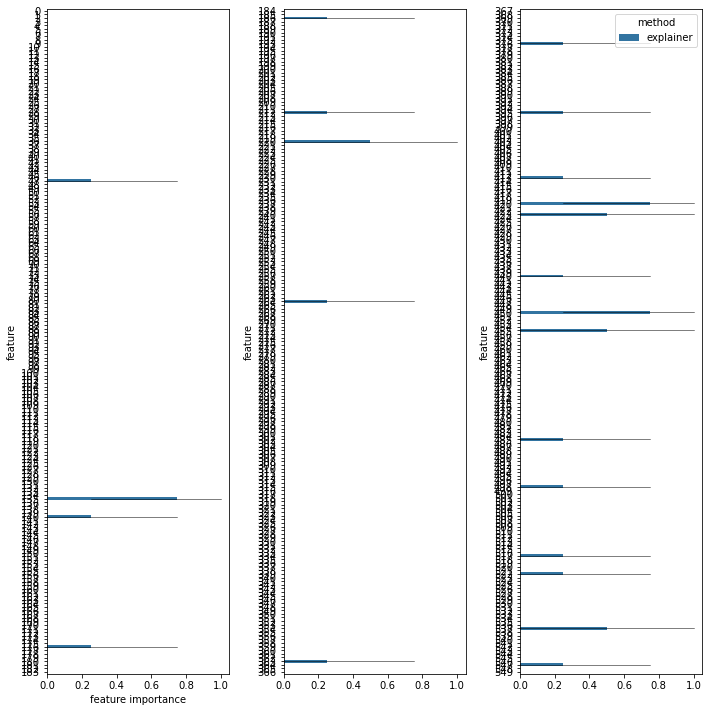

Split [1/4]
Split [2/4]
Split [3/4]
Split [4/4]


100%|██████████| 1/1 [01:49<00:00, 109.48s/it]

Random forest scores: 0.9529321571893693 (+/- 0.002924262112303946)
Decision tree scores: 0.9476066984679842 (+/- 0.005788961438981018)
Mu net scores (model): 0.9564845561981201 (+/- 0.0017240532153057677)
Mu net scores (exp): 0.017748091603053434 (+/- 0.03549618320610687)


In [105]:

for type in tqdm(extractedCat.mappedTypes):

    data = extractedCat.mappedTypes[type]

    # obj = imblearn.over_sampling.SMOTEN(random_state=0)

    print(sorted(Counter(targetSeriesFormatted).items()))

    # new_x, new_y = obj.fit_resample(data.to_numpy(), targetSeries)

    print(sorted(Counter(targetSeriesFormatted).items()))

    xTensor = torch.FloatTensor(data.to_numpy())
    yTensor = one_hot(torch.tensor(targetSeriesFormatted).to(torch.long)).to(torch.float)

    print(xTensor, yTensor)

    scorer = Scorer(data=xTensor, target=yTensor, concept_names=data.columns)

    scorer.train()

    scorer.explain()
